## Import Cleaned Data

__DataFrames:__  
df_model - df with all the features (independent festures + Target)  
x - df with all independent features
y - df with dependent feature  
x_train - df with training data from x  
x_train_out - df with training data from x with outliers treatment applied  
x_test - df with test data from x  
x_test_out - df with test data from x with outliers treatment applied  



d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


CAPM
Import data from: ..\..\..\SampleData\Sample\LongTerm-DataPreparation_Skew.csv
Original CAPM is being used as Target
Nr of rows:
72538


<Figure size 432x288 with 0 Axes>

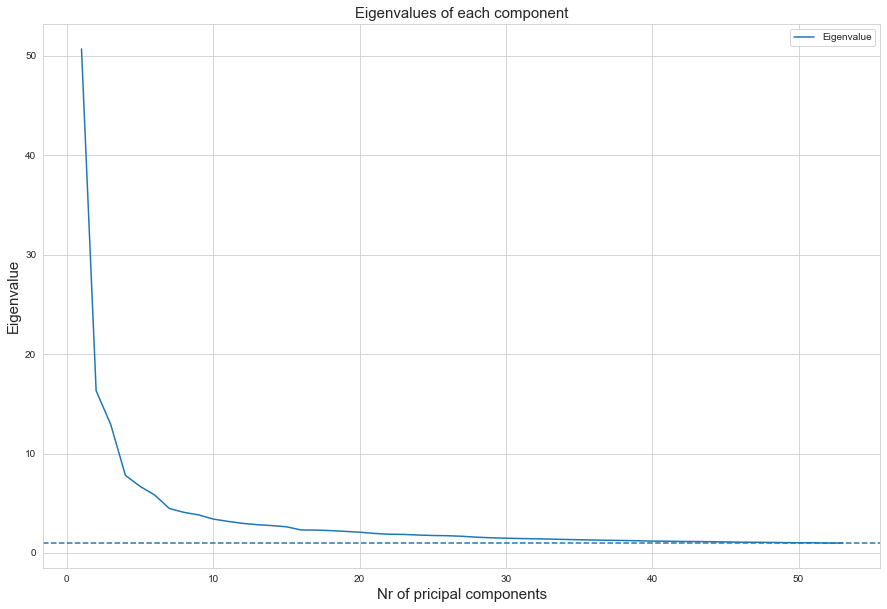

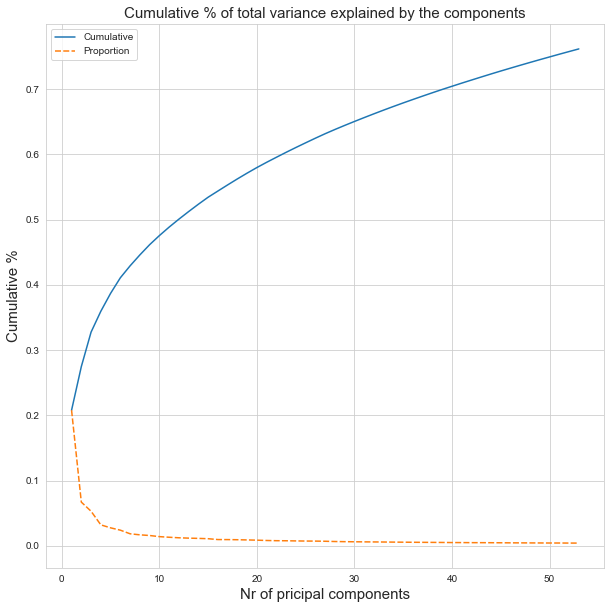

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001962


In [1]:
import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions\Functions')
sys.path.insert(3, r'..\..\..')


import Classification_CV as class_cv
import importCleanedData as importData
import importSubsets as subsets

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

# dir = r'C:\Users\rafae\Personal\Github\Asset-Allocation\Long-Term-CAPM\SampleData\Sample'
dir = r'..\..\..\SampleData\Sample'
df_model_skew,df_target = importData.importCleanedData(dir=dir,target='CAPM')


#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = importData.splitData(df_model_skew, date) 

#set columns
ratio_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Ratio'))]
shares_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Share'))]
margin_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Margin'))]
turnover_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Turnover'))]
dividend_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('dividend'))]


components_pca, pca_components_test = importData.runPCA(x_train_out= x_train_out,x_test = x_test)


#import subsets
lasso_subset_0, lasso_subset_15, mi_subset_0, mi_subset_15, lgb_subset, corr_subset0, corr_subset15 = subsets.importSubsets()


subset_0, subset_15 = lasso_subset_0, lasso_subset_15

# Train NN with PCA

In [2]:
def gen_NNClassification (x, y, hidden_layer_sizes,activation_list, dropout,optimizer,loss = 'BinaryCrossentropy', metrics = ['AUC'],batch_size=180,epochs=10,validation_split = 0.25, class_weight = None, output_bias =None ):
    
    print('Neural Network Parameters:')
    print(f'Optimizer: {optimizer}')
    print(f'Loss: {loss}')
    print(f'Hidden Layer tructure: {hidden_layer_sizes}')
    print(f'Acivation Functions: {activation_list}')
    print(f'Dropout: {dropout}')
    print(f'Class Weight: {class_weight}')
    print(f'Output Bias: {output_bias}')
    
    #import libraries
    from scikeras.wrappers import KerasClassifier, KerasRegressor
    from tensorflow import keras
    reset_random_seeds()
    #get nr features in
    n_features_in_ = x.shape[1]
    n_classes_ = len(y.unique())
    
    if output_bias is not None:
        output_bias =keras.initializers.Constant(output_bias)
    
    #set keras model
    model = keras.models.Sequential()
    
    #define input shape
    # model.add(keras.layers.Input(shape=(n_features_in_,)))
    model.add(keras.layers.Dense(
          4, activation='relu',
          input_shape=(n_features_in_,)))
    
    #define hidden layers
    for hidden_layer_size, activation_ in zip(hidden_layer_sizes,
                                              activation_list):
        
        model.add(keras.layers.Dense(hidden_layer_size,
                                     activation=activation_))
        
        model.add(keras.layers.Dropout(dropout))
    
    #define output layer
    model.add(keras.layers.Dense(1,
                                 activation="sigmoid",
                                 bias_initializer=output_bias))
    
    #compile model 
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics,
                  )
    
    #transform to SKlearn format
    NNmodel = KerasClassifier( model=model,
                            batch_size= batch_size,
                            epochs= epochs,
                            class_weight=class_weight,
                            validation_split=validation_split,
                            loss = loss)

    return NNmodel

metrics = ['AUC','Recall','Precision']


def reset_random_seeds():
    import random
    from numpy.random import seed
    import os
    import numpy as np 
    from tensorflow import random as r
    
    seed_nr = 0
    os.environ['PYTHONHASHSEED']=str(seed_nr)
    r.set_seed(seed_nr)
    np.random.seed(seed_nr)

from numpy.random import seed
from tensorflow import keras 


reset_random_seeds()
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_ = keras.losses.BinaryCrossentropy()
NNmodel = gen_NNClassification(components_pca, 
                                 y_train_dict['Target_0.15'],
                                 hidden_layer_sizes = (50,),
                                 activation_list = ['relu'],
                                 dropout = 0.3,
                                 optimizer =optimizer ,
                                 loss = loss_, 
                                 metrics = metrics,
                                 batch_size=64,
                                 epochs=15,
                                 validation_split = 0.25,
                                 class_weight = 'balanced',
                                 output_bias =None )

def roc_curve (models,names,X_train,y_train, X_val, y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        list with model names and a list of models 
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays ROC curve of the respective models 
    
    '''''''''''''''
    
    names= names
    from sklearn.metrics import roc_curve
    sns.set_theme(style = 'whitegrid')
    plt.figure(figsize = (10,10))
    for i, names ,in zip(models,names):
        # i.fit(X_train,y_train)
        thresh_dict = {}
        prob_model = i.predict_proba(X_val)
        
        fpr_DT_ent, tpr_DT_ent, thresholds_DT_ent = roc_curve(y_val, prob_model[:,1])
        plt.plot(fpr_DT_ent, tpr_DT_ent, label=f"ROC Curve {names}" , )
        
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
           
def precision_recall_curve (model,names, X_train,y_train,X_val,y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        model and respective name (string)
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays Precision - Recall  curve of the respective models 
    Note: the model is fitted inside the function 
    
    '''''''''''''''
    names=names
    model.fit(X_train,y_train)
    proba = model.predict_proba(X_val)
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_val, proba[:,1])

    # apply f1 score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    plt.figure(figsize = (10,10))
    plt.plot(recall, precision, marker='.', label=f'{names}')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    
def fitted_precision_recall_curve (model,names, X_train,y_train,X_val,y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        model and respective name (string)
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays Precision - Recall  curve of the respective models 
    Note: the model is fitted outside the function 
    
    '''''''''''''''
    names=names
    #model.fit(X_train,y_train)
    proba = model.predict_proba(X_val)
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_val, proba[:,1])

    # apply f1 score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    plt.figure(figsize = (10,10))
    plt.plot(recall, precision, marker='.', label=f'{names}')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def assessTest (x_test, y_test, model):
    
    col = x_test.columns[4]
    index__ = x_test.reset_index()[['symbol','fillingDate',col]].set_index(['symbol','fillingDate'])
    target_copy = df_target.copy()
    target_copy['fillingDate'] = target_copy['fillingDate'].astype(str)
    target_copy = target_copy.drop_duplicates(['symbol','fillingDate']).set_index(['symbol','fillingDate'])
    target_copy = target_copy.loc[target_copy.index.isin(index__.index)]
    
    assess_test_dict = dict()
    pred_test = model.predict(x_test)
    assess_test = pd.DataFrame(index = y_test.index)
    assess_test['Prediction'] = pred_test
    assess_test['Target'] = y_test
#     assess_test['returns'] = df_model.loc[df_model.index.isin(y_test.index),'futReturns']
    assess_test['excReturns'] = target_copy.loc[target_copy.index.isin(index__.index),'futAlpha']

    avg_returns = assess_test.groupby('Prediction').mean()[['excReturns']]


    from sklearn.metrics import roc_auc_score, precision_score, recall_score,accuracy_score
    auc  = roc_auc_score(assess_test['Target'],assess_test['Prediction'] )
    precision = precision_score(assess_test['Target'],assess_test['Prediction'] )
    recall =  recall_score(assess_test['Target'],assess_test['Prediction'] )
    acc =  accuracy_score(assess_test['Target'],assess_test['Prediction'] )
    
    assess_test_dict['accuracy'] = acc
    assess_test_dict['auc'] = auc
    assess_test_dict['precision'] = precision
    assess_test_dict['recall'] = recall
    return(assess_test_dict,assess_test)

Neural Network Parameters:
Optimizer: <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x000001BC8E4AE070>
Loss: <keras.losses.BinaryCrossentropy object at 0x000001BCD1519790>
Hidden Layer tructure: (50,)
Acivation Functions: ['relu']
Dropout: 0.3
Class Weight: balanced
Output Bias: None


## Target 15

Perfomance is compared using using standardized data since Neural Networks and Logistic Regressions are highly affected by data scalling.

In [8]:
#create a list of model and model names 

lr_model = LogisticRegression(class_weight='balanced', penalty=None, random_state=0,
                   solver='newton-cholesky')

model_list = [lr_model,NNmodel,]
model_names = ['LogisticRegression','NeuralNetwork',]


new_model_list = []
test_assess_list = []
full_assess = pd.DataFrame()
full_assess_test = pd.DataFrame()
predictions_df = pd.DataFrame()

#iterate over the models and perform CV 
for model, name in zip(model_list, model_names):
    assess = class_cv.validateModel(components_pca,
                                    y_train_dict['Target_0.15'],
                                    model=model ,
                                    scaler=False ,
                                    over_sampling=False,
                                    predictions=True,
                                    cv_type='stratKfold',
                                    scaler_type='stand',
                                    train_size=10,
                                    test_size=1,
                                    gap=0)
    
    #store scores
    assess_df = assess['scores']
    assess_df['model'] = name
    
    #store model 
    model = assess['model']
    new_model_list.append(model)
    
    predictions = assess['predictions']
    predictions['model'] = name
    predictions_df = pd.concat([predictions_df,predictions],
                               axis=0)
    

    full_assess = pd.concat([full_assess,
                             assess_df],
                            axis=0)
    
    
    
    X_test = pca_components_test
    assess_test_dict, assess_test_df = assessTest(X_test,
                                                  y_test_dict['Target_0.15'],
                                                  model)
    assess_test_dict['model'] = name
    assess_test_df['model'] = name
    
    full_assess_test = pd.concat([full_assess_test,
                                    assess_test_df],
                                    axis=0)
    test_assess_list.append(assess_test_dict)
    
    import joblib
    new_model_name = f'{name}_PCA.pkl'
    model_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Models\Final Models\\'
    joblib.dump(model, f'{model_path}{new_model_name}', compress=9)
    
test_assess_df = pd.DataFrame.from_records(test_assess_list)





stratKfold
Nr of splits: 10
accuracy_train     0.638998
f1_train           0.337689
recall_train       0.647843
precision_train    0.228370
auc_train          0.642688
accuracy_test      0.631615
f1_test            0.333395
recall_test        0.627572
precision_test     0.234048
auc_test           0.629931
dtype: float64
stratKfold
Nr of splits: 10
Epoch 1/15
555/555 [==============================] - 4s 8ms/step - loss: 0.6408 - auc: 0.6978 - recall: 0.7564 - precision: 0.2231 - val_loss: 0.6132 - val_auc: 0.6873 - val_recall: 0.5389 - val_precision: 0.2147
Epoch 2/15
555/555 [==============================] - 1s 2ms/step - loss: 0.6420 - auc: 0.6970 - recall: 0.7488 - precision: 0.2215 - val_loss: 0.6072 - val_auc: 0.6871 - val_recall: 0.5647 - val_precision: 0.2126
Epoch 3/15
555/555 [==============================] - 1s 2ms/step - loss: 0.6413 - auc: 0.6982 - recall: 0.7587 - precision: 0.2242 - val_loss: 0.6145 - val_auc: 0.6870 - val_recall: 0.5605 - val_precision: 0.2107
Epoch 4

INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpxc2loibk\assets


INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpxc2loibk\assets


In [23]:
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Validation\Full_Validation\full_CV_results_PCA.csv'
full_assess_ = pd.read_csv(path)

full_assess_ = full_assess_.loc[full_assess_['model'].isin(['LogisticRegression', 'NeuralNetwork'])==False]
full_assess_ = pd.concat([full_assess_,full_assess],axis=0)

full_assess_['subset'] = 'PCA'

full_assess_.drop(columns = ['Unnamed: 0',],).to_csv(path)

#### Display Training and Valdation Results

Export average scores from the Cross Validation

##### With Standartization inside CV

In [20]:
train_val_scores = full_assess.groupby('model').mean()
cols_ = train_val_scores.columns[train_val_scores.columns.str.contains('test')]
for col in cols_:
    
    new_col = col.replace('test','val')
    train_val_scores = train_val_scores.rename(columns = {col:new_col})
    
assess_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Validation\modelMetricPerfomance_Target_15_valSet_PCA.csv'
train_val_scores.to_csv(assess_path)
display(train_val_scores)

,accuracy_train,f1_train,recall_train,precision_train,auc_train,accuracy_val,f1_val,recall_val,precision_val,auc_val,Unnamed: 0
model,,,,,,,,,,,
DecisionTree,0.544844,0.602487,0.672910,0.550656,0.540043,0.514799,0.576056,0.646550,0.526109,0.509850,4.5
LightGB,0.568863,0.636858,0.729739,0.564964,0.562830,0.537835,0.609251,0.699172,0.542015,0.531783,4.5
LogisticRegression,0.548555,0.618256,0.705673,0.550151,0.542664,0.536066,0.600897,0.684193,0.542350,0.530511,4.5
MLP,0.575165,0.621495,0.673683,0.577143,0.571471,0.533784,0.585054,0.638700,0.542840,0.529849,4.5
NeuralNetwork,0.561731,0.568988,0.558921,0.580105,0.561837,0.547023,0.555546,0.549812,0.565264,0.546922,NaN


#### Display test Results

Export scores on test set

In [26]:
test_assess = test_assess.loc[test_assess['model']!='NeuralNetwork']

test_assess_df = pd.concat([test_assess,test_assess_df],axis=0)
test_assess_df['subset'] = 'PCA'

In [28]:
test_assess_df = test_assess_df.reset_index().set_index('model')
assess_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_0\Test\modelMetricPerfomance_Target_0_testSet_PCA.csv'
test_assess_df.to_csv(assess_path)
